# Construct knowledge graph

In [2]:
import pandas as pd
import duckdb
import networkx as nx

We tried to avoid doing any pre-processing of the files outside of the main script, but due to non-ascii characters and correctly escaping quote marks listed in terms' definitions. 

Specifically, we filter the concepts file (MRCONSO.RRF) by all English concepts. For the concept atom file ('MRSAT.RRF'), we omit the last column which provides text desciptions of how each atom is assigned. This information is not used in the construction of the KG. 

In [4]:
#awk -F'|' '$2 == "ENG"' MRCONSO.RRF > MRCONSO.ENG.RRF

## Nodes

The files are very large (9+GB). We recommend using duckdb which allows database style querying. Previous attempts at using pandas and polars resulted in memory errors.

In [2]:
concept_duckfile=duckdb.read_csv("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/data/2024AB/META/MRCONSO.ENG.RRF",
                          sep='|', header=False)
# ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF']

### ICD10-CM

In [3]:
icd10_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'ICD10CM'
    AND f.column16 != 'O'
    """
    ).df()
icd10_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
icd10_concept_df = icd10_concept_df.loc[~icd10_concept_df['CODE'].str.startswith(('A6', 'A7', 'B6', 'B7', 'B8', 'B9', 'Q', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))]

# Concepts that map to ranges of ICD10CM codes are often too broad and are omitted
icd10_concept_df = icd10_concept_df.loc[~icd10_concept_df['CODE'].str.contains('-')]

# only keep codes with 6 or less characters (two places after decimal point)
icd10_concept_df = icd10_concept_df.assign(len_icd=icd10_concept_df['CODE'].apply(lambda x: len(x)))
icd10_concept_df = icd10_concept_df.loc[icd10_concept_df['len_icd'] <= 5+1] # 6 bc of decimal points

n = len(icd10_concept_df)
print("Number of rows in ICD10CM concept df: %d" % n)

n = len(icd10_concept_df['CUI'].unique())
print("Number of CUI in ICD10CM concept df: %d" % n)

n = len(icd10_concept_df['CODE'].unique())
print("Number of codes in ICD10CM concept df: %d" % n)

icd10_concept_df.head()

Number of rows in ICD10CM concept df: 28464
Number of CUI in ICD10CM concept df: 17894
Number of codes in ICD10CM concept df: 13471


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x,len_icd
0,C0000727,ENG,P,L0000727,VCW,S0584932,N,A17803269,None,None,R10.0,ICD10CM,PT,R10.0,Acute abdomen,4,N,256.0,None,5
1,C0000727,ENG,P,L0000727,VCW,S0584932,N,A20117915,None,None,R10.0,ICD10CM,AB,R10.0,Acute abdomen,4,Y,256.0,None,5
2,C0000744,ENG,P,L0000744,PF,S0009088,N,A17774174,None,None,E78.6,ICD10CM,ET,E78.6,Abetalipoproteinemia,4,N,256.0,None,5
3,C0000770,ENG,P,L0000770,PF,S0218356,N,A17826655,None,None,K00.2,ICD10CM,PT,K00.2,Abnormalities of size and form of teeth,4,N,NaN,None,5
4,C0000770,ENG,P,L0000770,PF,S0218356,N,A20107438,None,None,K00.2,ICD10CM,AB,K00.2,Abnormalities of size and form of teeth,4,Y,NaN,None,5


### ATC

In [44]:
# ATC
atc_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'ATC'
    AND f.column16 != 'O'
    """
    ).df()
atc_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [46]:
# only keep ATC4 
atc_concept_df = atc_concept_df.assign(len_atc=atc_concept_df['CODE'].apply(len))
atc_concept_df = atc_concept_df.loc[atc_concept_df['len_atc'] == 5]

n = len(atc_concept_df)
print("Number of rows in ATC concept df: %d" % n)

n = len(atc_concept_df['CUI'].unique())
print("Number of CUI in ATC concept df: %d" % n)

n = len(atc_concept_df['CODE'].unique())
print("Number of codes in ATC concept df: %d" % n)

atc_concept_df.head()

Number of rows in ATC concept df: 877
Number of CUI in ATC concept df: 877
Number of codes in ATC concept df: 877


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x,len_atc
40,C0002007,ENG,P,L0002007,VC,S0354933,Y,A22722760,None,None,None,ATC,PT,C03DA,Aldosterone antagonists,0,N,256.0,None,5
99,C0003237,ENG,P,L0003237,PF,S0014490,N,A22726951,None,None,None,ATC,RXN_PT,J04AB,"Antibiotics, Antitubercular",0,N,256.0,None,5
100,C0003250,ENG,P,L0003250,VC,S1207558,Y,A36187032,None,None,None,ATC,PT,L04AG,Monoclonal antibodies,0,N,256.0,None,5
101,C0003295,ENG,P,L0003295,VO,S0014631,N,A22721684,None,None,None,ATC,PT,V03AB,Antidotes,0,N,256.0,None,5
181,C0005789,ENG,P,L0005789,VO,S0359137,Y,A22732625,None,None,None,ATC,PT,B02BD,Blood coagulation factors,0,N,256.0,None,5


### LOINC

In [10]:
loinc_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Loinc_2.76/LoincTable/Loinc.csv")

/tmp/ipykernel_1129375/4070014539.py:1: DtypeWarning: Columns (8,15,16,17,22,36,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  loinc_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Loinc_2.76/LoincTable/Loinc.csv")


In [8]:
loinc_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Loinc_2.76/AccessoryFiles/PartFile/LoincPartLink_Primary.csv")

In [18]:
top_loinc = loinc_df.loc[loinc_df['COMMON_TEST_RANK'].between(1, 10000)]['LOINC_NUM'].tolist()

In [20]:
top_lnc = loinc_map_df.loc[loinc_map_df['LoincNumber'].isin(top_loinc)]['PartNumber'].unique()

In [21]:
# LNC
lnc_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'LNC'
    AND f.column16 != 'O'
    """
    ).df()

lnc_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [22]:
loinc_part_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Loinc_2.76/AccessoryFiles/PartFile/Part.csv")
loinc_part_df = loinc_part_df.loc[loinc_part_df['Status'] == 'ACTIVE']

n = len(loinc_part_df)
print("Number of LOINC parts before filtering by part name: %d" % n)

loinc_part_df = loinc_part_df.loc[~loinc_part_df['PartTypeName'].isin(['ADJUSTMENT', 'CHALLENGE', 'COUNT', 'PROPERTY', 'SCALE', 'SUPER SYSTEM', 'TIME', 'TIME MODIFIER'])]

n = len(loinc_part_df)
print("Number of LOINC parts after filtering: %d" % n)

# filter concept df by loinc part numbers
#lnc_concept_df = lnc_concept_df.loc[lnc_concept_df['CODE'].isin(loinc_part_df['PartNumber'])]
lnc_concept_df = lnc_concept_df.loc[lnc_concept_df['CODE'].isin(top_lnc)]
n = len(lnc_concept_df)
print("Number of rows in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CUI'].unique())
print("Number of CUI in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CODE'].unique())
print("Number of codes in LOINC concept df: %d" % n)

lnc_concept_df.head()

Number of LOINC parts before filtering by part name: 69958
Number of LOINC parts after filtering: 67853
Number of rows in LOINC concept df: 8398
Number of CUI in LOINC concept df: 4643
Number of codes in LOINC concept df: 4704


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
3,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,None,LP15290-7,None,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256.0,None
5,C0000163,ENG,P,L0000163,PF,S0007806,N,A32789945,None,LP15290-7,None,LNC,LPDN,LP15290-7,17-Hydroxycorticosteroids,0,N,256.0,None
6,C0000167,ENG,P,L0000167,PF,S0007811,N,A18243505,None,LP17185-7,None,LNC,LPN,LP17185-7,17-Ketosteroids,0,N,256.0,None
8,C0000167,ENG,P,L0000167,PF,S0007811,N,A32815577,None,LP17185-7,None,LNC,LPDN,LP17185-7,17-Ketosteroids,0,N,256.0,None
9,C0000172,ENG,P,L0000172,PF,S0007830,N,A18282261,None,LP15293-1,None,LNC,LPN,LP15293-1,18-Hydroxycorticosterone,0,N,256.0,None


### SNOMED

In [23]:
# SNOMED
snomed_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'SNOMEDCT_US'
    AND f.column16 != 'O'
    """
    ).df()

snomed_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [24]:
# we limit inclusion to only the core subset of SNOMEDCT codes at this step (original set has 350K+ codes)
core_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/SNOMEDCT_CORE_SUBSET_202411/SNOMEDCT_CORE_SUBSET_202411.txt", sep='|')
core_df = core_df.loc[core_df['SNOMED_CONCEPT_STATUS'] == 'Current']
core_df = core_df.assign(SNOMED_CID=core_df['SNOMED_CID'].astype(str))

snomed_concept_df = snomed_concept_df.loc[snomed_concept_df['CODE'].isin(core_df['SNOMED_CID'].tolist())]

n = len(snomed_concept_df)
print("Number of rows in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CUI'].unique())
print("Number of CUI in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CODE'].unique())
print("Number of codes in SNOMEDCT concept df: %d" % n)

snomed_concept_df.head()

Number of rows in SNOMEDCT concept df: 6835
Number of CUI in SNOMEDCT concept df: 5781
Number of codes in SNOMEDCT concept df: 5602


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
40,C0000731,ENG,P,L0486265,PF,S0582832,N,A2987242,498835017,60728008,None,SNOMEDCT_US,SY,60728008,Abdomen distended,9,N,2304.0,None
41,C0000734,ENG,P,L0000734,PF,S0582855,N,A2987267,406851019,271860004,None,SNOMEDCT_US,PT,271860004,Abdominal mass,9,N,2304.0,None
42,C0000737,ENG,P,L0000737,VC,S0353662,Y,A2921922,36112013,21522001,None,SNOMEDCT_US,PT,21522001,Abdominal pain,9,N,2304.0,None
46,C0000768,ENG,P,L0009679,VC,S0844933,Y,A24082304,3006590016,276654001,None,SNOMEDCT_US,SY,276654001,Congenital abnormality,9,N,2304.0,None
50,C0000809,ENG,P,L0000809,VCW,S0898946,Y,A3139201,255965016,102878001,None,SNOMEDCT_US,SY,102878001,Habitual abortion,9,N,256.0,None


### RXNORM

In [47]:
rxnorm_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'RXNORM'
    AND f.column16 != 'O'
    """
    ).df()

rxnorm_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [48]:
atcprod_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/atc_prod.csv")
atcprod_df = atcprod_df.loc[atcprod_df['atc_prod'] != 'XXXX']

In [49]:
keep_rxcui = atcprod_df['rxcui'].astype('str').unique()

In [50]:
prescribe_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/RxNorm_full_04012024/prescribe/rrf/RXNCONSO.RRF", sep='|', header=None)
prescribe_df[0] = prescribe_df[0].astype(str)

rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['CODE'].isin(prescribe_df[0].tolist())]

# limit to term types: ingredient, particular ingredient, multiple ingredient, Semantic clinical drug and form, Semantic clinical drug group with precise ingredient as basis of strength
rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['TTY'].isin(['IN', 'PIN', 'MIN', 'SCDG', 'SCDGP'])] 

rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['CODE'].isin(keep_rxcui)]

n = len(rxnorm_concept_df)
print("Number of rows in RXNORM concept df: %d" % n)

n = len(rxnorm_concept_df['CUI'].unique())
print("Number of CUI in RXNORM concept df: %d" % n)

n = len(rxnorm_concept_df['CODE'].unique())
print("Number of codes in RXNORM concept df: %d" % n)

rxnorm_concept_df.head()

Number of rows in RXNORM concept df: 11164
Number of CUI in RXNORM concept df: 11164
Number of codes in RXNORM concept df: 11164


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
2,C0000294,ENG,P,L0025479,PF,S0525354,N,A31762929,12251526,44,None,RXNORM,IN,44,mesna,0,N,4352.0,None
3,C0000378,ENG,P,L0565039,PF,S14426412,N,A31685600,12254325,1489913,None,RXNORM,IN,1489913,droxidopa,0,N,4352.0,None
5,C0000464,ENG,P,L0012967,PF,S19607957,N,A31643165,12252051,73,None,RXNORM,IN,73,docosahexaenoate,0,N,4352.0,None
6,C0000473,ENG,P,L0000473,PF,S1424701,N,A31643235,12253228,74,None,RXNORM,IN,74,4-aminobenzoic acid,0,N,4352.0,None
7,C0000477,ENG,P,L9064747,PF,S11309189,N,A17289901,3052450,897018,None,RXNORM,IN,897018,dalfampridine,0,N,4352.0,None


### ATOMS from PheMap CUI's
Source codes for core CUI codes listed in PheMap

In [35]:
# limit cui to those in phemap
phemap_cui_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/PheMap_UMLS_Concepts_1.1.csv")
phemap_cui_df = phemap_cui_df.assign(PHECODE=phemap_cui_df['PHECODE'].astype(str))
core_cui_list = phemap_cui_df['CUI'].tolist()

In [58]:
atom_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 IN {['ATC', 'ICD10CM', 'RXNORM', 'SNOMEDCT_US', 'LNC']}
    AND f.column16 != 'O'
    """
    ).df()
atom_df.columns = ['CUI', 'SAB', 'CODE', 'STR']

atom_df = atom_df.loc[atom_df['CUI'].isin(core_cui_list)]

# filtering to prevent loinc-answers
atom_df = atom_df.loc[(atom_df['SAB'] == 'LNC') & (atom_df['CODE'].str.startswith('LP')) | (atom_df['SAB'] != 'LNC')]
atom_df[['SAB', 'CODE']].drop_duplicates().groupby('SAB').count()

atom_df.to_csv("atom_df.csv", sep='|', index=False)

print(atom_df.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(34543, 4)


### Phecodes

In [203]:
phecode_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Phecode_map_v1_2_icd9_icd10cm_09_30_2024.csv")
phecode_map_df = phecode_map_df.assign(Phecode=phecode_map_df['Phecode'].astype(str))

phecode_map_df = phecode_map_df.loc[(phecode_map_df['Flag'] == 10) & 
                   (~phecode_map_df['ICD'].str.startswith(('Q', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z')))]
phecode_map_df = phecode_map_df.loc[(phecode_map_df['Flag'] == 10) & 
                   (phecode_map_df['ICD'].str.len() <= 6)]

phecode_concept_df = phecode_map_df[['Phecode', 'PhecodeString']].drop_duplicates()
phecode_concept_df.columns = ['node_id', 'node_name']
phecode_concept_df['ntype'] = 'PHECODE'
phecode_concept_df['node_id'] = phecode_concept_df['node_id'] + ':phecode'
phecode_concept_df.head(2)

,node_id,node_name,ntype
14648,942.0:phecode,Infusion and transfusion reaction,PHECODE
14651,198.2:phecode,Secondary malignancy of respiratory organs,PHECODE


In [204]:
phecode_concept_df.shape

(1576, 3)

### Core CUI

In [205]:
phemap_cui_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/PheMap_UMLS_Concepts_1.1.csv")
phemap_cui_df = phemap_cui_df.loc[phemap_cui_df['PHECODE'].isin(phecode_map_df['Phecode'].astype(float))]
phemap_cui_df = phemap_cui_df.assign(PHECODE=phemap_cui_df['PHECODE'].astype(str))
core_cui_list = phemap_cui_df['CUI'].tolist()

core_cui_list = list(set(core_cui_list))

cui_concept_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
        AND f.column11 IN {['ATC', 'ICD10CM', 'RXNORM', 'SNOMEDCT_US', 'LNC', 'MED-RT']}
            AND f.column16 != 'O'
    """
    ).df()

cui_concept_df.columns = ['CUI', 'SAB', 'CODE', 'STR']
cui_concept_df = cui_concept_df.loc[cui_concept_df['CUI'].isin(core_cui_list)].drop_duplicates('CUI', keep='first')
cui_concept_df = cui_concept_df.drop(['SAB', 'CODE'], axis=1)
cui_concept_df.columns = ['node_id', 'node_name']
cui_concept_df['ntype'] = 'UMLS_CUI'
cui_concept_df['node_id'] = cui_concept_df['node_id'] + ':umls_cui'
cui_concept_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(23479, 3)

### Extra node filtering

In [206]:
# limit ICD10 codes that have a phecode
print("Before filtering: %d" % len(icd10_concept_df))

icd10_concept_df = icd10_concept_df.loc[(icd10_concept_df['CODE'].isin(phecode_map_df.loc[phecode_map_df['Flag'] == 10]['ICD'].tolist()))]

print("After filtering: %d" % len(icd10_concept_df))

Before filtering: 25352
After filtering: 25352


In [207]:
# filter rxnorm to those connected to atc ingredient (plus rxnorm filters)
print("Before filtering rxnorm: %d" % len(rxnorm_concept_df))
atcprod_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/atc_prod.csv")
atcprod_df = atcprod_df.loc[atcprod_df['atc_prod'] != 'XXXX']
atcprod_df.columns = ['column00', 'column04']
atcprod_df['column07'] = 'atc_prod'
atcprod_df['column00'] = atcprod_df['column00'].astype(str)
atcprod_df = atcprod_df.loc[atcprod_df['column00'].isin(rxnorm_concept_df['CODE']) & 
                      atcprod_df['column04'].isin(atc_concept_df['CODE'])]

rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['CODE'].isin(atcprod_df['column00'])]

print("After filtering rxnorm: %d" % len(rxnorm_concept_df))


Before filtering rxnorm: 9877
After filtering rxnorm: 9877


### Assemble all nodes

In [ ]:
# start with source code from core cui codes
atom_df = pd.read_csv("atom_df.csv", sep='|')
atom_df['node_id'] = atom_df['CODE'] + ':' + atom_df['SAB'].str.lower()
atom_df['node_name'] = atom_df['STR'].copy()
atom_df['ntype'] =  atom_df['SAB'].copy()
atom_df = atom_df[['node_id', 'node_name', 'ntype', 'CODE']]

atom_df = atom_df.loc[((atom_df['ntype'] == 'ATC') & (atom_df['CODE'].str.len() == 5)) | (atom_df['ntype'] != 'ATC')]
atom_df = atom_df.loc[((atom_df['ntype'] == 'SNOMEDCT_US') & (atom_df['CODE'].isin(core_df['SNOMED_CID'].tolist())) ) | (atom_df['ntype'] != 'SNOMEDCT_US')]
atom_df = atom_df.loc[((atom_df['ntype'] == 'LNC') & (atom_df['CODE'].isin(top_lnc))) | (atom_df['ntype'] != 'LNC')]
atom_df = atom_df.loc[((atom_df['ntype'] == 'RXNORM') & (atom_df['CODE'].isin(keep_rxcui))) | (atom_df['ntype'] != 'RXNORM')]

In [212]:
# nodes pulled by SAB
all_concept_df = pd.concat([icd10_concept_df, atc_concept_df, rxnorm_concept_df, 
                            lnc_concept_df, snomed_concept_df])[['CODE', 'SAB', 'STR', 'CUI']]
all_concept_df.columns = ['node_id', 'ntype', 'node_name', 'CUI']
all_concept_df['node_id'] = all_concept_df['node_id'] + ':' + all_concept_df['ntype'].str.lower() 
print(all_concept_df.drop_duplicates().shape)
all_concept_df.head()

(38950, 4)


,node_id,ntype,node_name,CUI
0,R10.0:icd10cm,ICD10CM,Acute abdomen,C0000727
1,R10.0:icd10cm,ICD10CM,Acute abdomen,C0000727
2,E78.6:icd10cm,ICD10CM,Abetalipoproteinemia,C0000744
3,K00.2:icd10cm,ICD10CM,Abnormalities of size and form of teeth,C0000770
4,K00.2:icd10cm,ICD10CM,Abnormalities of size and form of teeth,C0000770


In [213]:
# SAB nodes, src nodes from core-cui atoms, phecodes, core cui
node_df = pd.concat([all_concept_df, atom_df, phecode_concept_df, cui_concept_df])[['node_id', 'node_name', 'ntype']].drop_duplicates(['node_id'])

print("Total number of nodes: %d" % node_df.shape[0])

# keep old node-id for constructing edges
all_concept_df['old_node_id'] = all_concept_df['node_id'].str.split(':', expand=True)[0]

Total number of nodes: 59635


In [214]:
node_df.to_csv("node_logml_df.csv", sep='\t', index=False)

In [215]:
# node type counts
node_df.groupby('ntype').count()

,node_id,node_name
ntype,,
ATC,877,877
ICD10CM,12511,12511
LNC,4704,4704
PHECODE,1576,1576
RXNORM,10886,10886
SNOMEDCT_US,5602,5602
UMLS_CUI,23479,23479


## Edges

In [216]:
rel_duckfile=duckdb.read_csv("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/data/2024AB/META/MRREL.RRF",
                          sep='|', header=False)

### Get RXPROD ingredients (ATC4-RxNorm)

In [217]:
import requests
import json
from tqdm.notebook import tqdm

#rx_list = atom_df.loc[atom_df['SAB'] == 'RXNORM']['CODE'].unique()
#len(rx_list)

In [40]:
#atcprod_list = []

#for rxcui in tqdm(rx_list): 
#    url="https://rxnav.nlm.nih.gov/REST/rxclass/class/byRxcui.json?rxcui={}&relaSource=ATCPROD".format(rxcui)
#    response = requests.get(url)

#    if response.status_code == 200:
#        obj = json.loads(response.text)

#        if len(obj.keys()) > 0:
#            atc_id = obj['rxclassDrugInfoList']['rxclassDrugInfo'][0]['rxclassMinConceptItem']['classId']
#        else:
#            atc_id = 'XXXX'
            #print(rxcui)
#    else:
#        atc_id = 'XXXX'
        #print(rxcui)
        
#    atcprod_list.append(atc_id)
#atcprod_df = pd.DataFrame({'rxcui': rx_list, 'atc_prod': atcprod_list})
#atcprod_df.to_csv("atc_prod.csv", sep=',', index=False)

In [218]:
atcprod_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/atc_prod.csv")
atcprod_df = atcprod_df.loc[atcprod_df['atc_prod'] != 'XXXX']
atcprod_df.columns = ['column00', 'column04']
atcprod_df['column07'] = 'atc_prod'
atcprod_df['column00'] = atcprod_df['column00'].astype(str)

atcprod_df = atcprod_df.loc[atcprod_df['column00'].isin(rxnorm_concept_df['CODE']) & 
                      atcprod_df['column04'].isin(atc_concept_df['CODE'])]

atcprod_df = atcprod_df.merge(rxnorm_concept_df[['CODE', 'STR']], left_on='column00', right_on='CODE').drop(['CODE'], axis=1)
atcprod_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'node_name_x']
atcprod_df = atcprod_df.merge(atc_concept_df[['CODE', 'STR']], left_on='node_id_y', right_on='CODE').drop(['CODE'], axis=1)

atcprod_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'node_name_x', 'node_name_y']
atcprod_df['node_id_x'] = atcprod_df['node_id_x'] + ':' + 'rxnorm'
atcprod_df['node_id_y'] = atcprod_df['node_id_y'] + ':' + 'atc'

atcprod_df['ntype_x'] = 'RXNORM'
atcprod_df['ntype_y'] = 'ATC'

### ATC5/RXNORM/LNC - RXNORM (ingredient-level) 

In [219]:
atc_ingred_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['RXNORM']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [220]:
atc_ingred_df = atc_ingred_df.loc[atc_ingred_df['column00'].isin(all_concept_df['CUI']) & 
                      atc_ingred_df['column04'].isin(all_concept_df['CUI'])]

atc_ingred_df.columns = ['CUI_1', 'CUI_2', 'relationship']
atc_ingred_df = atc_ingred_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
atc_ingred_df = atc_ingred_df.drop(['CUI'],axis=1)


atc_ingred_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

atc_ingred_df = atc_ingred_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

atc_ingred_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
atc_ingred_df = atc_ingred_df.loc[atc_ingred_df['CODE_1'] != atc_ingred_df['CODE_2']].drop_duplicates()

atc_ingred_df = atc_ingred_df.loc[(atc_ingred_df['relationship']=='ingredient_of')]
atc_ingred_df = atc_ingred_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

atc_ingred_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

### MED-RT cui-cui

In [221]:
medrt_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column07 IN {['may_prevent', 'may_treat', 'may_be_treated_by', 'may_be_prevented_by']}
    AND f.column11 = 'MED-RT'
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [222]:
medrt_relation_df = medrt_relation_df.loc[medrt_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      medrt_relation_df['column04'].isin(all_concept_df['CUI'])]

# add back source nodes from cui
medrt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
medrt_relation_df = medrt_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
medrt_relation_df = medrt_relation_df.drop(['CUI'],axis=1)


medrt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']
medrt_relation_df = medrt_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)
medrt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
medrt_relation_df = medrt_relation_df.loc[medrt_relation_df['CODE_1'] != medrt_relation_df['CODE_2']].drop_duplicates()

medrt_relation_df = medrt_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]
medrt_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']
medrt_relation_df.shape

(24792, 7)

### ATC - ATC/RXNORM 'member-of'/'is-a'

In [223]:
atc_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['ATC']
    """
).df()
atc_relation_df = atc_relation_df.loc[atc_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      atc_relation_df['column04'].isin(all_concept_df['CUI'])]

atc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
atc_relation_df = atc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
atc_relation_df = atc_relation_df.drop(['CUI'],axis=1)


atc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

atc_relation_df = atc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

atc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
atc_relation_df = atc_relation_df.loc[atc_relation_df['CODE_1'] != atc_relation_df['CODE_2']].drop_duplicates()

atc_relation_df = atc_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

atc_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']
atc_relation_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(5400, 7)

### RXNORM 'ingredient'/'form-of'

In [224]:
rxnorm_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['RXNORM']
    """
).df()
rxnorm_relation_df = rxnorm_relation_df.loc[rxnorm_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      rxnorm_relation_df['column04'].isin(all_concept_df['CUI'])]

rxnorm_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
rxnorm_relation_df = rxnorm_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
rxnorm_relation_df = rxnorm_relation_df.drop(['CUI'],axis=1)


rxnorm_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

rxnorm_relation_df = rxnorm_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

rxnorm_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
rxnorm_relation_df = rxnorm_relation_df.loc[rxnorm_relation_df['CODE_1'] != rxnorm_relation_df['CODE_2']].drop_duplicates()

rxnorm_relation_df = rxnorm_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

rxnorm_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']
rxnorm_relation_list = ['has_part', 'has_ingredient', 'has_form', 'part_of', 'ingredient_of', 'form_of']
rxnorm_relation_df = rxnorm_relation_df.loc[rxnorm_relation_df['relationship'].isin(rxnorm_relation_list)]

rxnorm_relation_df.head()
rxnorm_relation_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(29906, 7)

### LOINC (labs related to each other)

In [225]:
lnc_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['LNC']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [226]:
lnc_relation_df = lnc_relation_df.loc[lnc_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      lnc_relation_df['column04'].isin(all_concept_df['CUI'])]

lnc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
lnc_relation_df = lnc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
lnc_relation_df = lnc_relation_df.drop(['CUI'],axis=1)


lnc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

lnc_relation_df = lnc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

lnc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
lnc_relation_df = lnc_relation_df.loc[lnc_relation_df['CODE_1'] != lnc_relation_df['CODE_2']].drop_duplicates()

lnc_relation_df = lnc_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

lnc_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

### SNOMEDCT 'assoc-with'/'causes'/'other'

In [227]:
snomed_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['SNOMEDCT_US']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [228]:
snomed_relation_df = snomed_relation_df.loc[snomed_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      snomed_relation_df['column04'].isin(all_concept_df['CUI'])]

snomed_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
snomed_relation_df = snomed_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
snomed_relation_df = snomed_relation_df.drop(['CUI'],axis=1)

snomed_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

snomed_relation_df = snomed_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

snomed_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
snomed_relation_df = snomed_relation_df.loc[snomed_relation_df['CODE_1'] != snomed_relation_df['CODE_2']].drop_duplicates()

snomed_relation_df = snomed_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

snomed_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

all_snomed_relation_df = snomed_relation_df.copy()
keep_list = ['cause_of', 'due_to', 'definitional_manifestation_of', 
             'has_definitional_manifestation', 'occurs_after', 'occurs_before', 'associated_with'] 
# 'has_associated_morphology', 'associated_morphology_of'

snomed_relation_df = snomed_relation_df.loc[snomed_relation_df['relationship'].isin(keep_list)]
snomed_relation_df.shape

(3894, 7)

In [229]:
# CPT: isa, inverse_isa
# ICD9CM: all
# ICD10CM: all
# ATC: all
# RXNORM: all (has_part, has_ingredient, has_form)
# LNC: all
# SNOMED: 'isa', 'inverse_isa', 'possibly_equivalent_to', 'partially_equivalent_to'

### PHECODE edges (ICD9/10-Phecode)

In [230]:
phecode_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Phecode_map_v1_2_icd9_icd10cm_09_30_2024.csv")
phecode_map_df = phecode_map_df.assign(Phecode=phecode_map_df['Phecode'].astype(str))

phecode_icd10_df = phecode_map_df.loc[(phecode_map_df['Flag']==10) & (phecode_map_df['ICD'].isin(icd10_concept_df['CODE']))]
phecode_icd10_df = phecode_icd10_df[['ICD', 'ICDString', 'Phecode', 'PhecodeString']]
phecode_icd10_df.columns = ['node_id_x', 'node_name_x', 'node_id_y', 'node_name_y']

phecode_icd10_df['node_id_x'] = phecode_icd10_df['node_id_x'] + ':' + 'icd10cm'
phecode_icd10_df['node_id_y'] = phecode_icd10_df['node_id_y'] + ':' + 'phecode'

phecode_icd10_df['ntype_x'] = 'ICD10CM'
phecode_icd10_df['ntype_y'] = 'PHECODE'

### PheMap UMLS edges

In [231]:
phemap_cui_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/PheMap_UMLS_Concepts_1.1.csv")
phemap_cui_df = phemap_cui_df.assign(PHECODE=phemap_cui_df['PHECODE'].astype(str))
phecode_concept_df['new_node_id'] = phecode_concept_df['node_id'].str.split(':', expand=True)[0]
phemap_cui_df = phemap_cui_df.merge(phecode_concept_df, left_on='PHECODE', right_on='new_node_id').drop(['new_node_id', 'PHECODE', 'ntype', 'TFIDF'], axis=1)

phemap_cui_df.columns = ['node_id_x', 'node_id_y', 'node_name_y']
phemap_cui_df['ntype_y'] = 'PHECODE'
phemap_cui_df
cui_concept_df['new_node_id'] = cui_concept_df['node_id'].str.split(':', expand=True)[0]

phemap_cui_df = phemap_cui_df.merge(cui_concept_df, left_on='node_id_x', right_on='new_node_id').drop(['new_node_id', 'node_id'], axis=1)
phemap_cui_df.columns = ['node_id_x', 'node_id_y', 'node_name_y', 'ntype_y', 'node_name_x', 'ntype_x']

phemap_cui_df['node_id_y'] = phemap_cui_df['node_id_y'] 
phemap_cui_df['node_id_x'] = phemap_cui_df['node_id_x'] + ':' + 'umls_cui'

### Phemap expanded edges

In [232]:
cui_atom_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 IN {['ATC', 'ICD10CM', 'RXNORM', 'SNOMEDCT_US', 'LNC']}
    AND f.column16 != 'O'
    """
    ).df()
cui_atom_df.columns = ['CUI', 'SAB', 'CODE', 'STR']

cui_atom_df = cui_atom_df.loc[cui_atom_df['CUI'].isin(core_cui_list)]

# filtering to prevent loinc-answers
cui_atom_df = cui_atom_df.loc[(cui_atom_df['SAB'] == 'LNC') & (cui_atom_df['CODE'].str.startswith('LP')) | (cui_atom_df['SAB'] != 'LNC')]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [233]:
cui_atom_df.columns = ['CUI', 'ntype', 'node_id', 'node_name']
cui_atom_df['node_id'] = cui_atom_df['node_id'] + ':' + cui_atom_df['ntype'].str.lower()

phemap_expand_df = phemap_cui_df.copy()

phemap_expand_df['CUI'] = phemap_expand_df['node_id_x'].str.split(':', expand=True)[0]
combo_concept_df = pd.concat([all_concept_df, cui_atom_df])

phemap_expand_df = combo_concept_df.merge(phemap_expand_df[['node_id_y', 'node_name_y', 'ntype_y', 'CUI']], on='CUI').drop(['CUI', 'old_node_id'], axis=1)
phemap_expand_df.columns = ['node_id_x', 'ntype_x', 'node_name_x', 'node_id_y', 'node_name_y', 'ntype_y']
phemap_expand_df = phemap_expand_df.drop_duplicates()

In [234]:
phemap_expand_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/PheMap_Mapped_Terminologies_1.1.csv")
phemap_expand_df = phemap_expand_df.assign(PHECODE=phemap_expand_df['PHECODE'].astype(str))

phemap_expand_df.columns = ['PHECODE', 'CODE', 'SAB', 'phemap_code_desc', 'TFIDF']
phemap_expand_df.head(2)
temp_df = phemap_expand_df.merge(all_concept_df[['ntype', 'old_node_id', 'node_name']], left_on=['SAB', 'CODE'], right_on=['ntype', 'old_node_id'])

obs_phemap_snomed = phemap_expand_df.loc[(~phemap_expand_df['CODE'].isin(temp_df['CODE']) )& (phemap_expand_df['SAB'] == 'SNOMEDCT_US')]['CODE'].tolist()
temp_df['STR'] = temp_df['node_name']

old_snomed_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    WHERE f.column11 IN {['SNOMEDCT_US']}
    """
).df()


old_snomed_df = old_snomed_df.loc[old_snomed_df['column13'].isin(obs_phemap_snomed)][['column00', 'column11', 'column13']].drop_duplicates()

snomed_cui_dict = {}

for i, row in old_snomed_df.iterrows():
    cui = row['column00']
    snomed_code = row['column13']
    snomed_cui_dict[snomed_code] = cui
new_cui_snomed_dict = {}

for i, row in snomed_concept_df.iterrows():
    cui = row['CUI']
    code = row['CODE']
    new_cui_snomed_dict[cui] = code
    
obs_phemap_snomed_df = phemap_expand_df.loc[phemap_expand_df['CODE'].isin(obs_phemap_snomed)]
obs_phemap_snomed_df = obs_phemap_snomed_df.assign(CUI=[snomed_cui_dict[x] for x in obs_phemap_snomed_df['CODE'].tolist()])

obs_phemap_snomed_df = obs_phemap_snomed_df.assign(NEW_SNOMEDCT=obs_phemap_snomed_df['CUI'].map(new_cui_snomed_dict))
obs_phemap_snomed_df['CODE'] = obs_phemap_snomed_df['NEW_SNOMEDCT'].copy()

new_phemap_expand_df = pd.concat([temp_df.drop(['STR'], axis=1), obs_phemap_snomed_df.dropna().drop(['NEW_SNOMEDCT', 'CUI'], axis=1)])
new_phemap_expand_df.columns = ['node_id_x', 'CODE', 'SAB', 'node_name_x', 'x', 'ntype', 'old_node_id', 'node_id']
new_phemap_expand_df = new_phemap_expand_df.merge(all_concept_df[['ntype', 'old_node_id', 'node_name']], left_on=['SAB', 'CODE'], right_on=['ntype', 'old_node_id'])
new_phemap_expand_df = new_phemap_expand_df[['node_id_x', 'CODE', 'SAB', 'node_name_x']]
new_phemap_expand_df.columns = ['node_id_x', 'node_id_y', 'ntype_y', 'node_name_y']

new_phemap_expand_df['ntype_x'] = 'PHECODE'
new_phemap_expand_df['node_id_x'] = new_phemap_expand_df['node_id_x'] + ':' + new_phemap_expand_df['ntype_x'].str.lower()
new_phemap_expand_df['node_id_y'] = new_phemap_expand_df['node_id_y'] + ':' + new_phemap_expand_df['ntype_y'].str.lower()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Atom edges (CUI-source_code)

In [235]:
atom_df = pd.read_csv("atom_df.csv", sep='|')
edge_atom_df = atom_df.copy()
edge_atom_df.columns = ['node_id_x', 'ntype_y', 'node_id_y', 'node_name_y']

edge_atom_df = edge_atom_df.merge(all_concept_df[['CUI', 'node_name']], left_on='node_id_x', right_on='CUI').drop(['CUI'], axis=1)
edge_atom_df.columns = ['node_id_x', 'ntype_y', 'node_id_y', 'node_name_y', 'node_name_x']

edge_atom_df['node_id_y'] = edge_atom_df['node_id_y'] + ':' + edge_atom_df['ntype_y'].str.lower()
edge_atom_df['ntype_x'] = 'UMLS_CUI'
edge_atom_df['node_id_x'] = edge_atom_df['node_id_x'] + ':' + edge_atom_df['ntype_x'].str.lower()

### SNOMED-ICD10CM edges

In [236]:
snomed_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/SnomedCT_ManagedServiceUS_PRODUCTION_US1000124_20240301T120000Z 2/Full/Refset/Map/der2_iisssccRefset_ExtendedMapFull_US1000124_20240301.txt", sep='\t')
snomed_map_df['referencedComponentId'] = snomed_map_df['referencedComponentId'].astype(str)
snomed_map_df['mapTarget'] = snomed_map_df['mapTarget'].astype(str)

snomed_map_df = snomed_map_df.loc[(snomed_map_df['referencedComponentId'].isin(all_concept_df.loc[all_concept_df['ntype'] == 'SNOMEDCT_US']['old_node_id'].tolist())) & 
                  (snomed_map_df['mapTarget'].isin(all_concept_df.loc[all_concept_df['ntype']=='ICD10CM']['old_node_id'].tolist()))]

snomed_map_df = snomed_map_df.loc[(snomed_map_df['active'] == 1)]

snomed_map_df = snomed_map_df[['referencedComponentId', 'mapTarget']]
snomed_map_df.columns = ['node_id_x', 'node_id_y']
snomed_map_df = snomed_map_df.assign(relationship='snomed_icd')
snomed_map_df = snomed_map_df.assign(ntype_x='SNOMEDCT_US')
snomed_map_df = snomed_map_df.assign(ntype_y='ICD10CM')

snomed_map_df = snomed_map_df.merge(snomed_concept_df[['CODE', 'STR']], left_on='node_id_x', right_on='CODE').drop(['CODE'], axis=1)
snomed_map_df = snomed_map_df.merge(icd10_concept_df[['CODE', 'STR']], left_on='node_id_y', right_on='CODE').drop(['CODE'], axis=1)

snomed_map_df['node_id_x'] = snomed_map_df['node_id_x'] + ':' + 'snomedct_us'
snomed_map_df['node_id_y'] = snomed_map_df['node_id_y'] + ':' + 'icd10cm'
snomed_map_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x', 'node_name_y']

### Phecode-cui

In [237]:
icd_phecode_10_map = phecode_map_df.loc[phecode_map_df['Flag'] == 10].merge(icd10_concept_df, left_on='ICD', right_on='CODE')
phecode_cui_10_df = icd_phecode_10_map[['Phecode', 'CUI', 'PhecodeString']].drop_duplicates()
phecode_cui_10_df.columns = ['node_id_x', 'node_id_y', 'node_name_x']
phecode_cui_10_df = phecode_cui_10_df.assign(ntype_x='PHECODE')
phecode_cui_10_df = phecode_cui_10_df.assign(ntype_y='UMLS_CUI')

phecode_cui_10_df = phecode_cui_10_df.merge(all_concept_df[['CUI', 'node_name']], left_on='node_id_y', right_on='CUI').drop(['CUI'], axis=1)

phecode_cui_10_df.columns = ['node_id_x', 'node_id_y', 'node_name_x', 'ntype_x', 'ntype_y', 'node_name_y']
phecode_cui_10_df['node_id_x'] = phecode_cui_10_df['node_id_x'] + ':' + phecode_cui_10_df['ntype_x'].str.lower()

phecode_cui_10_df['node_id_y'] = phecode_cui_10_df['node_id_y'] + ':' + phecode_cui_10_df['ntype_y'].str.lower()

### ATC-phecode edges (inhereted from PheMap rxnorm)

In [238]:
atc_rx_df = atcprod_df.loc[(atcprod_df['ntype_x'] == 'RXNORM')][['node_id_x', 'node_id_y']].drop_duplicates()

rx_atc_dict = {}
for i, row in atc_rx_df.iterrows():
    k = row['node_id_x']
    v = row['node_id_y']
    rx_atc_dict[k] = v

In [239]:
phemap_atc_rx_df = new_phemap_expand_df.loc[new_phemap_expand_df['ntype_y'] == 'RXNORM']
phemap_atc_rx_df['node_id_y'] = phemap_atc_rx_df['node_id_y'].map(rx_atc_dict)
phemap_atc_rx_df['ntype_y'] = 'ATC'

/tmp/ipykernel_1129375/987749768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phemap_atc_rx_df['node_id_y'] = phemap_atc_rx_df['node_id_y'].map(rx_atc_dict)
/tmp/ipykernel_1129375/987749768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phemap_atc_rx_df['ntype_y'] = 'ATC'


In [240]:
phemap_atc_rx_df.head()

,node_id_x,node_id_y,ntype_y,node_name_y,ntype_x
514,8.0:phecode,V07AB:atc,ATC,Water,PHECODE
528,8.0:phecode,S01AE:atc,ATC,Ciprofloxacin,PHECODE
577,8.0:phecode,P01AB:atc,ATC,Metronidazole,PHECODE
1774,8.5:phecode,S01AE:atc,ATC,Ciprofloxacin,PHECODE
1862,8.5:phecode,V07AB:atc,ATC,Water,PHECODE


## Combine all nodes and edges

In [241]:
atcprod_df['relationship'] = 'DEFINED'
atc_ingred_df['relationship'] = 'DEFINED'
medrt_relation_df['relationship'] = 'ASSOC'
atc_relation_df['relationship'] = 'DEFINED'
rxnorm_relation_df['relationship'] = 'DEFINED'
lnc_relation_df['relationship'] = 'DEFINED'
snomed_relation_df['relationship'] = 'ASSOC'
phecode_icd10_df['relationship'] = 'DEFINED'
phemap_cui_df['relationship'] = 'ASSOC'
new_phemap_expand_df['relationship'] = 'ASSOC'
edge_atom_df['relationship'] = 'DEFINED'
snomed_map_df['relationship'] = 'DEFINED'
phecode_cui_10_df['relationship'] = 'DEFINED'
phemap_atc_rx_df['relationship'] = 'ASSOC'

edge_df = pd.concat([
    atcprod_df,
    atc_ingred_df,
    medrt_relation_df,
    lnc_relation_df,
    snomed_relation_df,
    phecode_icd10_df,
    phemap_cui_df,
    new_phemap_expand_df,
    edge_atom_df,
    snomed_map_df,
    phecode_cui_10_df,
    phemap_atc_rx_df
                    ])

/tmp/ipykernel_1129375/2339057977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phemap_atc_rx_df['relationship'] = 'ASSOC'


In [242]:
edge_df['relationship'].unique()

array(['DEFINED', 'ASSOC'], dtype=object)

In [243]:
edge_df[['node_id_x', 'node_id_y', 'relationship']].drop_duplicates().shape

(458325, 3)

In [244]:
edge_x_list = edge_df['node_id_x'].tolist() +  edge_df['node_id_y'].tolist()
edge_y_list = edge_df['node_id_y'].tolist() +  edge_df['node_id_x'].tolist()

edge_relationship_list = edge_df['relationship'].tolist() +  edge_df['relationship'].tolist()

edge_ntype_x_list = edge_df['ntype_x'].tolist() +  edge_df['ntype_y'].tolist()
edge_ntype_y_list = edge_df['ntype_y'].tolist() +  edge_df['ntype_x'].tolist()

new_edge_df = pd.DataFrame({'node_id_x': edge_x_list, 'node_id_y': edge_y_list, 
                        'relationship': edge_relationship_list,
                        'ntype_x': edge_ntype_x_list,
                        'ntype_y': edge_ntype_y_list}).drop_duplicates(['node_id_x', 'relationship', 'node_id_y'])
new_edge_df.shape


(890720, 5)

In [245]:
node_df = pd.read_csv("node_logml_df.csv", sep='\t')

edge_df = new_edge_df.merge(node_df, left_on='node_id_x', right_on='node_id').drop(['ntype', 'node_id'], axis=1)

#edge_df.columns = ['node_id_x', 'node_name_', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x']

edge_df = edge_df.merge(node_df, left_on='node_id_y', right_on='node_id').drop(['ntype', 'node_id'], axis=1)
edge_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x', 'node_name_y']

edge_df = edge_df[['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']]
edge_df.shape

(824192, 7)

In [246]:
# reset index
node_df = node_df.reset_index().drop(['index'], axis=1)
node_df['node_index'] = node_df.index

edge_df = edge_df.merge(node_df[['node_id', 'node_index']], left_on='node_id_x', right_on='node_id').drop(['node_id'], axis=1)
edge_df = edge_df.merge(node_df[['node_id', 'node_index']], left_on='node_id_y', right_on='node_id').drop(['node_id'], axis=1)

edge_df = edge_df.reset_index().drop(['index'], axis=1)
edge_df = edge_df.assign(edge_index=edge_df.index)
#edge_df['relationship'] = edge_df['ntype_x'].str.lower() + ':' + edge_df['ntype_y'].str.lower()

print("Number of edges: %d" % len(edge_df))


Number of edges: 824192


In [247]:
edge_df.to_csv("edge_logml_df.csv", sep='\t', index=False)

In [4]:
edge_df = pd.read_csv("edge_logml_df.csv", sep='\t')

In [8]:
edge_df.loc[(edge_df['node_index_y']== 14094) & (edge_df['node_index_x']==12750)]

,node_id_x,node_name_x,ntype_x,relationship,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
425061,M03AC:atc,"Other quaternary ammonium compounds in ATC, mu...",ATC,DEFINED,71535:rxnorm,vecuronium,RXNORM,12750,14094,425061


## NetworkX graph

In [10]:
edge_df = pd.read_csv("edge_logml_df.csv", sep='\t')
edge_df[['node_index_x', 'node_index_y']].to_csv("adj_list_logml.csv", sep=' ', index=False, header=False)
g = nx.read_adjlist("adj_list_logml.csv")

print("Number of nodes: %d" % len(list(g.nodes())))
print("Number of edges: %d" % len(list(g.edges())))

largest_cc = max(nx.connected_components(g), key=len)
s = g.subgraph(largest_cc).copy()
keep_node_list = list(s.nodes())
keep_node_list = [int(x) for x in keep_node_list]

connected_node_df = node_df.loc[node_df['node_index'].isin(keep_node_list)]
old_index = connected_node_df['node_index'].tolist()
connected_node_df = connected_node_df.reset_index().drop(['index'], axis=1)
new_index = list(connected_node_df.index)

Number of nodes: 54066
Number of edges: 400080


NameError: name 'node_df' is not defined

In [ ]:
index_map = {}
for old_i, new_i in zip(old_index, new_index):
    index_map[old_i] = new_i

connected_node_df['node_index'] = connected_node_df['node_index'].map(index_map)

connected_edge_df = edge_df.loc[(edge_df['node_index_x'].isin(keep_node_list)) & edge_df['node_index_y'].isin(keep_node_list)]

connected_edge_df['node_index_x'] = connected_edge_df['node_index_x'].map(index_map)
connected_edge_df['node_index_y'] = connected_edge_df['node_index_y'].map(index_map)

connected_edge_df = connected_edge_df.reset_index()
#connected_edge_df = connected_node_df.reset_index().drop(['index'], axis=1)
connected_edge_df['edge_index'] = list(connected_edge_df.index)

/tmp/ipykernel_1129375/2585135818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_edge_df['node_index_x'] = connected_edge_df['node_index_x'].map(index_map)
/tmp/ipykernel_1129375/2585135818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_edge_df['node_index_y'] = connected_edge_df['node_index_y'].map(index_map)


In [251]:
connected_edge_df['edge_index'].max()

823133

In [252]:
connected_edge_df.to_csv("connected_edge_logml_df.csv", sep='\t', index=False)
connected_node_df.to_csv("connected_node_logml_df.csv", sep='\t', index=False)

In [253]:
print("Final number of nodes: %d" % len(connected_node_df))
print("Final number of edges: %d" % len(connected_edge_df))

Final number of nodes: 53447
Final number of edges: 823134


In [254]:
connected_node_df.groupby('ntype').count()
# minority etypes: ATC, CPT, PHECODE

,node_id,node_name,node_index
ntype,,,
ATC,606,606,606
ICD10CM,11933,11933,11933
LNC,1682,1682,1682
PHECODE,1519,1519,1519
RXNORM,9849,9849,9849
SNOMEDCT_US,4379,4379,4379
UMLS_CUI,23479,23479,23479


In [255]:
connected_edge_df.groupby('relationship').count()

,index,node_id_x,node_name_x,ntype_x,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
relationship,,,,,,,,,,
ASSOC,725736,725736,725736,725736,725736,725736,725736,725736,725736,725736
DEFINED,97398,97398,97398,97398,97398,97398,97398,97398,97398,97398


In [256]:
connected_edge_df['ntype_relationship'] = connected_edge_df['ntype_x'] + ':' + connected_edge_df['ntype_y']

In [257]:
connected_edge_df.groupby(['ntype_relationship', 'relationship']).count().sort_values(by='index', ascending=False).head(50)

,,index,node_id_x,node_name_x,ntype_x,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
ntype_relationship,relationship,,,,,,,,,,
PHECODE:ICD10CM,ASSOC,230700,230700,230700,230700,230700,230700,230700,230700,230700,230700
ICD10CM:PHECODE,ASSOC,230700,230700,230700,230700,230700,230700,230700,230700,230700,230700
UMLS_CUI:PHECODE,ASSOC,84638,84638,84638,84638,84638,84638,84638,84638,84638,84638
PHECODE:UMLS_CUI,ASSOC,84638,84638,84638,84638,84638,84638,84638,84638,84638,84638
SNOMEDCT_US:PHECODE,ASSOC,22657,22657,22657,22657,22657,22657,22657,22657,22657,22657
PHECODE:SNOMEDCT_US,ASSOC,22657,22657,22657,22657,22657,22657,22657,22657,22657,22657
RXNORM:RXNORM,DEFINED,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
PHECODE:ICD10CM,DEFINED,12067,12067,12067,12067,12067,12067,12067,12067,12067,12067
ICD10CM:PHECODE,DEFINED,12067,12067,12067,12067,12067,12067,12067,12067,12067,12067


In [258]:
import torch
connected_node_df = pd.read_csv("connected_node_logml_df.csv", sep='\t')

n_feat=128
xavier_tensor = torch.empty(len(connected_node_df), n_feat)
torch.nn.init.xavier_uniform_(xavier_tensor)
graph_feature_df = pd.DataFrame(xavier_tensor.numpy())
graph_feature_df.to_csv("graph_feature_logml_df.csv", index=False)

In [ ]:
import torch
connected_node_df = pd.read_csv("connected_node_v3_df.csv", sep='\t')

n_feat=1024
xavier_tensor = torch.empty(len(connected_node_df), n_feat)
torch.nn.init.xavier_uniform_(xavier_tensor)
graph_feature_df = pd.DataFrame(xavier_tensor.numpy())
#graph_feature_df.to_csv("graph_feature_v3_1024_df.csv", index=False)

### Node degree

In [11]:
edge_df = pd.read_csv("connected_edge_logml_df.csv", sep='\t')
edge_df[['node_index_x', 'node_index_y']].to_csv("connected_adj_list_logml.csv", sep=' ', index=False, header=False)

In [12]:
s = nx.read_adjlist("connected_adj_list_logml.csv")

In [13]:
node_df = pd.read_csv("connected_node_logml_df.csv", sep='\t')
node_df.head()

,node_id,node_name,ntype,node_index
0,R10.0:icd10cm,Acute abdomen,ICD10CM,0
1,E78.6:icd10cm,Abetalipoproteinemia,ICD10CM,1
2,K00.2:icd10cm,Abnormalities of size and form of teeth,ICD10CM,2
3,O03:icd10cm,Spontaneous abortion,ICD10CM,3
4,O03.9:icd10cm,Spontaneous abortion NOS,ICD10CM,4


In [191]:
node_degree_list = list(s.degree())

node_ids = [x[0] for x in node_degree_list]
degrees = [x[1] for x in node_degree_list]

degree_df = pd.DataFrame({'node_id': node_ids, 'n': degrees})
degree_df.columns = ['node_index', 'n']
degree_df.sort_values(by='n', ascending=False)

,node_index,n
34376,29101,1073
19368,29141,987
17090,28836,963
15157,28590,854
19550,29163,842
...,...,...
39528,47271,1
39529,37605,1
39534,46771,1
39535,30064,1


In [192]:
degree_df['node_index'] = degree_df['node_index'].astype(int)

In [193]:
name_degree_df = degree_df.merge(node_df, on='node_index')

In [197]:
name_degree_df.loc[name_degree_df['n'] > 500].sort_values(by='n', ascending=False).head()

,node_index,n,node_id,node_name,ntype
34376,29101,1073,279.2:phecode,Autoimmune disease NEC,PHECODE
19368,29141,987,289.4:phecode,Lymphadenitis,PHECODE
17090,28836,963,745.0:phecode,Pain in joint,PHECODE
15157,28590,854,371.1:phecode,"Uveitis, noninfectious or NOS",PHECODE
19550,29163,842,379.1:phecode,Scleritis and episcleritis,PHECODE


In [22]:
name_degree_df.to_csv("name_degree_df.csv")

<Axes: xlabel='n', ylabel='Count'>

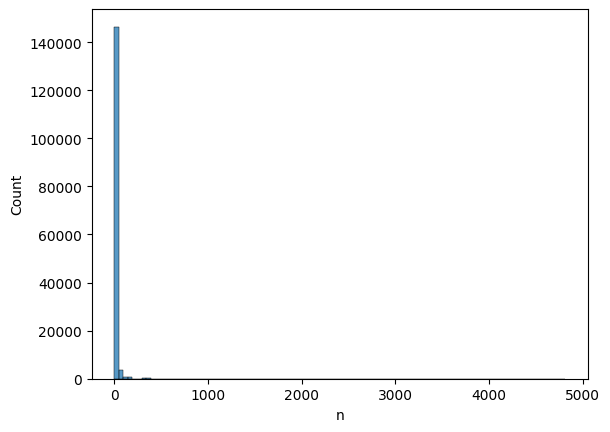

In [115]:
import seaborn as sns

sns.histplot(x=degree_df['n'], bins=100)

In [113]:
node_df.loc[node_df['node_index'] == 180287]

,node_id,node_name,ntype,node_index
180287,773.0:phecode,Pain in limb,PHECODE,180287


In [119]:
degree_df['node_id'] = degree_df['node_id'].astype(int)

In [121]:
degree_df = degree_df.merge(node_df, left_on='node_id', right_on='node_index')

In [218]:
connected_edge_df.groupby('relationship').count()

,index,node_id_x,node_name_x,ntype_x,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
relationship,,,,,,,,,,
atc:atc,8920,8920,8920,8920,8920,8920,8920,8920,8920,8920
atc:cpt,4,4,4,4,4,4,4,4,4,4
atc:icd10cm,4267,4267,4267,4267,4267,4267,4267,4267,4267,4267
atc:icd9cm,3500,3500,3500,3500,3500,3500,3500,3500,3500,3500
atc:lnc,1292,1292,1292,1292,1292,1292,1292,1292,1292,1292
...,...,...,...,...,...,...,...,...,...,...
umls_cui:lnc,15941,15941,15941,15941,15941,15941,15941,15941,15941,15941
umls_cui:phecode,94533,94533,94533,94533,94533,94533,94533,94533,94533,94533
umls_cui:rxnorm,14460,14460,14460,14460,14460,14460,14460,14460,14460,14460


In [2]:
edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')

In [ ]:
# NetworkX adj list
edge_df[['node_index_x', 'node_index_y']].to_csv("ClinGraph_adjlist.csv", sep=' ', index=False, header=False)
g = nx.read_adjlist("ClinGraph_adjlist.csv")

In [ ]:
# DGL 
import dgl 
import torch 

print("Assembling graph")
node_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_node_v3_df.csv", sep='\t')
edge_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_edge_v3_df.csv", sep='\t')

u = torch.tensor(edge_df['node_index_x'].tolist())
v = torch.tensor(edge_df['node_index_y'].tolist())

g = dgl.graph((u,v))
graph_feature_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/graph_feature_v3_df.csv")
g.ndata['feat'] = torch.tensor(graph_feature_df.values, dtype=torch.float32)

ntype_list = node_df['ntype'].unique()
ntype_dict = {}
ntype_index_dict = {}
i = 0
for t in ntype_list:
    ntype_dict[t] = i
    ntype_index_dict[i] = t
    i+=1 

ntype_index_dict = {}
ntype_index_dict['ATC'] = 0
ntype_index_dict['CPT'] = 1
ntype_index_dict['ICD9CM'] = 2
ntype_index_dict['ICD10CM'] = 2
ntype_index_dict['LNC'] = 1
ntype_index_dict['PHECODE'] = 2
ntype_index_dict['RXNORM'] = 0
ntype_index_dict['SNOMEDCT_US'] = 3
ntype_index_dict['UMLS_CUI'] = 3

node_df['ntype_index'] = node_df['ntype'].map(ntype_index_dict)
g.ndata['ntype'] = torch.tensor(node_df['ntype_index'].tolist(), dtype=torch.int32)
from dgl.data.utils import save_graphs
save_graphs("harvard_dataverse/ClinGraph_dgl.bin", [g])

Assembling graph


In [ ]:
from torch_geometric.data import Data

edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')

# Define edge indices
edge_index = torch.tensor([edge_df['node_index_x'].tolist(),
                           edge_df['node_index_y'].tolist()], dtype=torch.long)

graph_feature_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/graph_feature_v3_df.csv")

# Define node features
x = torch.tensor(graph_feature_df.values, dtype=torch.float)

# Create a Data object
data = Data(x=x, edge_index=edge_index)

# Save the entire dataset
torch.save(data, 'harvard_dataverse/ClinGraph_pyg.pt')

In [39]:
edge_df.head()

,index,node_id_x,node_name_x,ntype_x,relationship,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
0,1,72962:rxnorm,docetaxel,RXNORM,DEFINED,L01CD:atc,"Taxanes, antineoplastic",ATC,51205,48315,0
1,2,3966:rxnorm,ephedrine,RXNORM,DEFINED,R05CA:atc,Expectorants,ATC,50241,45362,1
2,3,3992:rxnorm,epinephrine,RXNORM,DEFINED,N01BB:atc,Amide local anesthetics,ATC,50242,48159,2
3,4,4099:rxnorm,"estrogens, conjugated (USP)",RXNORM,DEFINED,G03FA:atc,"Progestogens and estrogens, fixed combinations",ATC,50252,48248,3
4,5,4451:rxnorm,flucytosine,RXNORM,DEFINED,J02AX:atc,Other antimycotics for systemic use in ATC,ATC,50280,48953,4


# Embedding versions

In [40]:
import pandas as pd
import pickle 
import torch

def to_pickle(df, f):
    with open(f, 'wb') as fname:
        pickle.dump(df, fname)

def open_pickle(f):
    with open(f, 'rb') as file:
        data = pickle.load(file)
    return data

In [ ]:
phekg_node_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_node_v3_df.csv", sep='\t')

phekg_cui_embeds = open_pickle("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_cui.pkl")
phekg_cui_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'UMLS_CUI']
df = pd.DataFrame(phekg_cui_embeds, index=phekg_cui_df['node_index'].tolist())
df.to_csv("ClinVec_umls.csv", header=True, index=True, sep=',')

In [47]:
phekg_atc_embeds = open_pickle("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_atc.pkl")
phekg_atc_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'ATC']
df = pd.DataFrame(phekg_atc_embeds, index=phekg_atc_df['node_index'].tolist())
df.to_csv("ClinVec_atc.csv", header=True, index=True, sep=',')

In [48]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_phecode.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'PHECODE']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_phecode.csv", header=True, index=True, sep=',')

In [49]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_snomed.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'SNOMEDCT_US']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_snomedct.csv", header=True, index=True, sep=',')

In [50]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_icd10.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'ICD10CM']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_icd10cm.csv", header=True, index=True, sep=',')

In [51]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_icd9.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'ICD9CM']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_icd9cm.csv", header=True, index=True, sep=',')

In [52]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_rxnorm.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'RXNORM']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_rxnorm.csv", header=True, index=True, sep=',')

In [54]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_lnc.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'LNC']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_lnc.csv", header=True, index=True, sep=',')

In [55]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_cpt.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'CPT']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_cpt.csv", header=True, index=True, sep=',')

In [60]:
import pandas as pd

# load phecode embeddings
df = pd.read_csv("ClinVec_phecode.csv")

# get matrix of embeddings
emb_mat = df.values

# get node metadata
node_df = pd.read_csv("ClinGraph_nodes.csv", sep='\t')
df['node_index'] = df.index
phecode_emb_df = df.merge(node_df, how='inner', on='node_index')

In [61]:
phecode_emb_df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,122,123,124,125,126,127,node_index,node_id,node_name,ntype
0,108490,-8.252774,-10.008340,2.450239,-2.365206,-7.629035,11.505103,0.366181,-4.933194,-9.669165,...,-8.244699,-6.517928,2.705620,-5.787675,6.872317,-8.468920,0,789.0:icd9cm,Abdominal pain,ICD9CM
1,108491,-8.759756,-7.133308,-0.627591,-5.206552,-8.022506,8.743834,-1.098971,-2.765118,-8.495240,...,-8.503339,-2.618777,3.638133,-5.833642,2.361309,-5.447535,1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM
2,108492,-7.579075,-6.282095,-1.794689,-4.666381,-8.040098,7.720970,-3.089917,-3.691666,-5.454268,...,-7.485843,-1.101381,4.932792,-6.409150,0.024862,-2.871532,2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM
3,108493,-7.207140,-4.191913,-4.604074,-4.674320,-5.553472,5.562275,-4.345500,-2.256395,-2.670582,...,-5.768753,2.112556,4.058359,-5.652261,-3.922810,0.382054,3,634:icd9cm,Spontaneous abortion,ICD9CM
4,108494,-8.582227,-6.140819,-1.450412,-5.249937,-8.146950,7.984882,-1.404204,-1.571751,-7.364511,...,-8.569725,-0.165040,4.300578,-5.792841,0.494873,-4.165176,4,632:icd9cm,Missed abortion,ICD9CM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,110278,-3.424452,-2.121988,-4.841920,-4.049212,-2.471359,1.758095,-7.240350,-4.843853,2.086054,...,-1.672188,-0.364733,1.992002,-3.699849,-4.539177,2.655902,1788,013.61:icd9cm,"Tuberculous encephalitis or myelitis, bacterio...",ICD9CM
1789,110279,-6.614455,-9.505219,2.283926,-1.451893,-5.941207,9.677986,-4.883672,-4.014568,-2.128048,...,-7.291325,-1.840473,-0.446444,-1.946195,3.218427,-8.037433,1789,013.62:icd9cm,"Tuberculous encephalitis or myelitis, bacterio...",ICD9CM
1790,110280,-2.991784,-1.437084,-4.994030,-4.623467,-2.881358,1.089833,-6.769373,-5.178181,1.444817,...,-1.420049,-1.236986,2.900282,-4.283151,-4.355249,3.338756,1790,013.63:icd9cm,"Tuberculous encephalitis or myelitis, tubercle...",ICD9CM
1791,110281,-2.098383,-2.825050,-3.688952,-2.618571,-3.607536,2.546577,-7.454947,-7.396249,2.553179,...,-1.089605,-2.311492,4.140357,-5.175703,-3.235469,3.099006,1791,013.64:icd9cm,"Tuberculous encephalitis or myelitis, tubercle...",ICD9CM


# KG summary statistics

In [ ]:
import pandas as pd

new_node_df = pd.read_csv("connected_node_v3_df.csv", sep='\t')
old_node_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper/construct_kg/phekg/new_node_map_df.csv")

In [ ]:
# new node counts
new_node_df.groupby('ntype').count()

,node_id,node_name,node_index
ntype,,,
ATC,5179,5179,5179
CPT,4377,4377,4377
ICD10CM,34842,34842,34842
ICD9CM,10157,10157,10157
LNC,14399,14399,14399
PHECODE,1793,1793,1793
RXNORM,10130,10130,10130
SNOMEDCT_US,29406,29406,29406
UMLS_CUI,42883,42882,42883


In [53]:
new_node_df.loc[(new_node_df['ntype'] == 'ATC') & (new_node_df['node_id'].str.len() < 11)]

,node_id,node_name,ntype,node_index
44846,C03DA:atc,Aldosterone antagonists,ATC,44846
44848,L01A:atc,ALKYLATING AGENTS,ATC,44848
44849,V01A:atc,ALLERGENS,ATC,44849
44890,N02A:atc,OPIOID ANALGESICS,ATC,44890
44892,G03B:atc,ANDROGENS,ATC,44892
...,...,...,...,...
107822,V01:atc,ALLERGENS,ATC,107822
107894,C03:atc,DIURETICS,ATC,107894
108228,N02:atc,ANALGESICS,ATC,108228
108417,A11:atc,VITAMINS,ATC,108417


In [7]:
# old node counts
old_node_df.groupby('ntype').count()

,node_name,node_id,global_graph_index
ntype,,,
ATC4,474,474,474
CPT,952,952,952
ICD9CM,15202,15202,15202
LNC,8063,8063,8063
PHECODE,1761,1761,1761
RXNORM,2119,2119,2119
SNOMEDCT_US,38553,38553,38553


In [10]:
# lnc
10130/2119. 

4.780556866446437

In [11]:
new_edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')

In [14]:
new_edge_df['etype'] = new_edge_df['ntype_x'] + '_' + new_edge_df['ntype_y']

In [47]:
new_edge_df.groupby('etype').count().sort_values(by='index', ascending=False).head(20)

,index,node_id_x,node_name_x,ntype_x,relationship,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
etype,,,,,,,,,,,
ICD10CM_PHECODE,782779,782779,782779,782779,782779,782779,782779,782779,782779,782779,782779
PHECODE_ICD10CM,782779,782779,782779,782779,782779,782779,782779,782779,782779,782779,782779
PHECODE_ICD9CM,244149,244149,244149,244149,244149,244149,244149,244149,244149,244149,244149
ICD9CM_PHECODE,244149,244149,244149,244149,244149,244149,244149,244149,244149,244149,244149
UMLS_CUI_PHECODE,140615,140615,140613,140615,140615,140615,140615,140615,140615,140615,140615
PHECODE_UMLS_CUI,140615,140615,140615,140615,140615,140615,140613,140615,140615,140615,140615
SNOMEDCT_US_ICD10CM,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000
ICD10CM_SNOMEDCT_US,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000,56000
SNOMEDCT_US_PHECODE,31186,31186,31186,31186,31186,31186,31186,31186,31186,31186,31186


In [39]:
new_edge_df['etype'].unique()

array(['RXNORM_ATC', 'RXNORM_RXNORM', 'RXNORM_LNC', 'LNC_ATC',
       'LNC_RXNORM', 'LNC_LNC', 'RXNORM_ICD10CM', 'RXNORM_SNOMEDCT_US',
       'LNC_ICD10CM', 'LNC_SNOMEDCT_US', 'ATC_ICD10CM', 'ATC_SNOMEDCT_US',
       'ICD9CM_RXNORM', 'ICD10CM_RXNORM', 'SNOMEDCT_US_RXNORM',
       'ICD10CM_LNC', 'SNOMEDCT_US_LNC', 'SNOMEDCT_US_ATC',
       'RXNORM_ICD9CM', 'LNC_ICD9CM', 'ICD9CM_ATC', 'ICD9CM_LNC',
       'ICD10CM_ATC', 'ATC_ICD9CM', 'ATC_LNC', 'CPT_LNC', 'LNC_CPT',
       'CPT_SNOMEDCT_US', 'CPT_CPT', 'SNOMEDCT_US_CPT', 'CPT_ICD10CM',
       'ICD10CM_CPT', 'ICD9CM_CPT', 'SNOMEDCT_US_SNOMEDCT_US', 'ATC_CPT',
       'SNOMEDCT_US_ICD10CM', 'CPT_ICD9CM', 'CPT_ATC',
       'ICD10CM_SNOMEDCT_US', 'ICD9CM_SNOMEDCT_US', 'SNOMEDCT_US_ICD9CM',
       'ATC_ATC', 'ATC_RXNORM', 'ICD9CM_ICD10CM', 'RXNORM_CPT',
       'ICD10CM_ICD9CM', 'CPT_RXNORM', 'ICD10CM_ICD10CM', 'ICD9CM_ICD9CM',
       'ICD10CM_PHECODE', 'ICD9CM_PHECODE', 'UMLS_CUI_PHECODE',
       'PHECODE_ICD9CM', 'PHECODE_SNOMEDCT_US', 'PHECO

In [18]:
new_edge_df.loc[(new_edge_df['etype'] == 'ICD10CM_ICD9CM') | (new_edge_df['etype'] == 'ICD9CM_ICD10CM')].shape

(29552, 12)

In [19]:
new_edge_df.loc[(new_edge_df['etype'] == 'ATC_RXNORM') | 
                (new_edge_df['etype'] == 'RXNORM_ATC')].shape

(37140, 12)

In [21]:
new_edge_df.loc[(new_edge_df['etype'] == 'ICD10CM_SNOMEDCT_US') | 
                (new_edge_df['etype'] == 'SNOMEDCT_US_ICD10CM')].shape

(112000, 12)

In [45]:
a = 'LNC'
b = 'ICD10CM'
new_edge_df.loc[(new_edge_df['etype'] == '{}_{}'.format(a,b)) | 
                (new_edge_df['etype'] == '{}_{}'.format(b,a))].shape

(3988, 12)

In [ ]:
import pandas as pd 
import dgl
import torch
import pytorch_lightning as pl
import umap
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt